## CARR-MADAN EXPLANATION

The payoff of a European call option is given by

$$C(K,T) = e^{-rT}\mathbb{E}^{\mathbb{Q}}\left[\max(S_T - K, 0)\right]$$
 
where the expectation under the risk-neutral measure can be written as
 
$$\mathbb{E}^{\mathbb{Q}}\left[\max(S_T - K, 0)\right] = \int_{-\infty}^{\infty} \max(x - K, 0) f_{S_T}(x) dx = \int_{K}^{\infty} (S_T - K) f_{S_T}(x) dx$$

This payoff function is not integrable in the Fourier sense.
To fix this, we introduce a damping factor $e^{\alpha k}$, where
$k=\ln K$ and $s=\ln S_0$. \
The damped call price is then defined as

 $$c_T(k) = e^{\alpha k}C_T(k)$$

The function c_T(k) is now integrable, and we can compute its Fourier transform:

 $$\psi_T(v) = \int_{-\infty}^{\infty} e^{ivk}c_T(k)dk$$

Inverting this transform yields the original call price:

 $$C_T(k)=\frac{e^{-\alpha k}}{2\pi}\int_{-\infty}^{\infty}e^{-ivk}\,\psi_T(v)\,dv
=\frac{e^{-\alpha k}}{\pi}\,\Re\!\int_{0}^{\infty}e^{-ivk}\,\psi_T(v)\,dv$$

(this is the one-sided representation, ff instead we integrate over the whole real line, the prefactor becomes $1/(2\pi)$).

In [29]:
import numpy as np
import matplotlib.pyplot as plt

# HESTON PARAMS 
S      = 105.0 # spot price
K      = 145   # strike price
T      = 1.5   # time to maturity (years)
r      = 0.09  # risk-free rate
q      = 0.0   # dividend yield
v0     = 0.075 # initial variance
kappa  = 4.0   # speed of mean reversion
theta  = 0.05  # long-term variance
sigma_v= 0.4   # vol-of-vol
rho    = -0.3  # correlation

i = 1j         # complex unit


# FFT PARAMS
alpha  = 1.5     # damping factor to make the Fourier transform integrable
N      = 4096    # number of FFT points (power of 2), determines the frequency-domain range
eta    = 0.1     # sampling step in the frequency domain (spacing between points)

The function phi(u) returns $\varphi(u)=\mathbb E[e^{iu\ln S_T}]=\exp\!\big(C + D v_0 + iu\ln S\big)$

In [30]:
# char funct of ln(S_T) (risk-neutral)
def phi(u):
    b_h = kappa #- rho*sigma_v 
    d = np.sqrt((rho*sigma_v*i*u - b_h)**2 + (sigma_v**2)*(i*u + u**2))
    g = (b_h - rho*sigma_v*i*u + d) / (b_h - rho*sigma_v*i*u - d)

    C = (r - q)*i*u*T + ((kappa * theta)/(sigma_v**2)) * (
        (b_h - rho*sigma_v*i*u + d)*T - 2*np.log((1 - g*np.exp(d*T))/(1 - g))
    )
    D = ((b_h - rho*sigma_v*i*u + d)/(sigma_v**2)) * (
        (1 - np.exp(d*T))/(1 - g*np.exp(d*T))
    )
    return np.exp(C + D*v0 + i*u*np.log(S))

The grid $u_j = j\eta$ is used for the numerical approximation of the integral as a summation:
$$\int f(u)\,du \approx \sum_j w_j\,f(u_j)$$

The weights represent the infinitesimal measure $du$.
When the integral is discretized, the differential du is replaced by the step size $\eta$.


In [41]:
# grid in the frequency domain
u = np.arange(N) * eta

# weights: trapezoidal rule (endpoints have half the weight of interior points)
w = np.ones(N)
w[0] = 0.5
w[-1] = 0.5
w *= eta

# weights using Simpson's rule (same results)
# w[0] = 1.0
# w[-1] = 1.0
# w[1:-1:2] = 4.0
# w[2:-1:2] = 2.0
# w *= eta/3.0

print('u: ', u)
print('w: ', w)

u:  [0.000e+00 1.000e-01 2.000e-01 ... 4.093e+02 4.094e+02 4.095e+02]
w:  [0.05 0.1  0.1  ... 0.1  0.1  0.05]


$$\psi(u)=\frac{e^{-rT}\,\varphi(u-i(\alpha+1))}
{\alpha^2+\alpha - u^2 + i(2\alpha+1)u}$$

In [42]:
# psi(u): includes damping, complex shift, discounting, and the denominator
uj = u - i*(alpha + 1.0)   # frequency grid with complex shift
numerator = np.exp(-r*T) * phi(uj)
denominator = (alpha**2 + alpha - u**2) + i*(2*alpha + 1.0)*u
denominator = np.where(np.abs(denominator) < 1e-14, 1e-14, denominator)  # safety clipping
psi = numerator / denominator

print('shifted grid u_j:', uj)
print('psi(u_j): ', psi)

shifted grid u_j: [0.000e+00-2.5j 1.000e-01-2.5j 2.000e-01-2.5j ... 4.093e+02-2.5j
 4.094e+02-2.5j 4.095e+02-2.5j]
psi(u_j):  [ 4.26075671e+004+0.00000000e+000j  3.93158956e+004+1.60450794e+004j
  3.00137216e+004+2.94350828e+004j ... -8.55489290e-155+1.28485449e-155j
 -7.40613260e-155-2.77027005e-155j -4.68840578e-155-5.50069984e-155j]


Be careful: the FFT does not return option prices directly, tt returns a sequence of values corresponding to the damped call prices:
$$\text{FFT}[m] \approx \int_0^\infty e^{-i u k_m}\,\psi(u)\,du$$
To recover the actual call price, we must remove the damping factor $e^{-\alpha k}$ \
Note: in this step we are working in the frequency domain, therefore we do not use $\varphi(u)$, but $\psi(u)$, which already includes the damping, the complex shift, discounting, and the denominator term from the Carr–Madan formula.

We build a grid of log-strikes $k$ centered around $\ln S$. Then we apply the phase shift $e^{-i k_{\min} u}$, compute the FFT, and obtain the damped call prices over the entire k-grid. \
Taking the real part and removing the damping yields:
$$C(k_m) = \frac{e^{-\alpha k_m}}{\pi}\,\Re\{\text{FFT}[m] \}$$

In [43]:
lam = 2.0 * np.pi / (N * eta)               
k_min = np.log(S) - (N * lam) / 2.0         
k_grid = k_min + np.arange(N) * lam   

print('k_grid:', k_grid)

# FFT input
fft_input = np.exp(-1j * k_min * u) * psi * w
fft_vals = np.fft.fft(fft_input)   # computes the discrete sum (u-domain → k-domain)
fft_real = np.real(fft_vals)       # take the real part (option prices are real)

print('FFT real:', fft_real)

# Call option prices for each strike K
C_k = (np.exp(-alpha * k_grid) / np.pi) * fft_real

print('Call prices C(k):', C_k)

k_grid: [-26.76196619 -26.74662638 -26.73128657 ...  36.02386746  36.03920727
  36.05454708]
FFT real: [-3.63797881e-12 -3.63797881e-12 -3.63797881e-12 ...  0.00000000e+00
  0.00000000e+00 -1.45519152e-11]
Call prices C(k): [-3.14464519e+05 -3.07311392e+05 -3.00320978e+05 ...  0.00000000e+00
  0.00000000e+00 -1.50776625e-35]


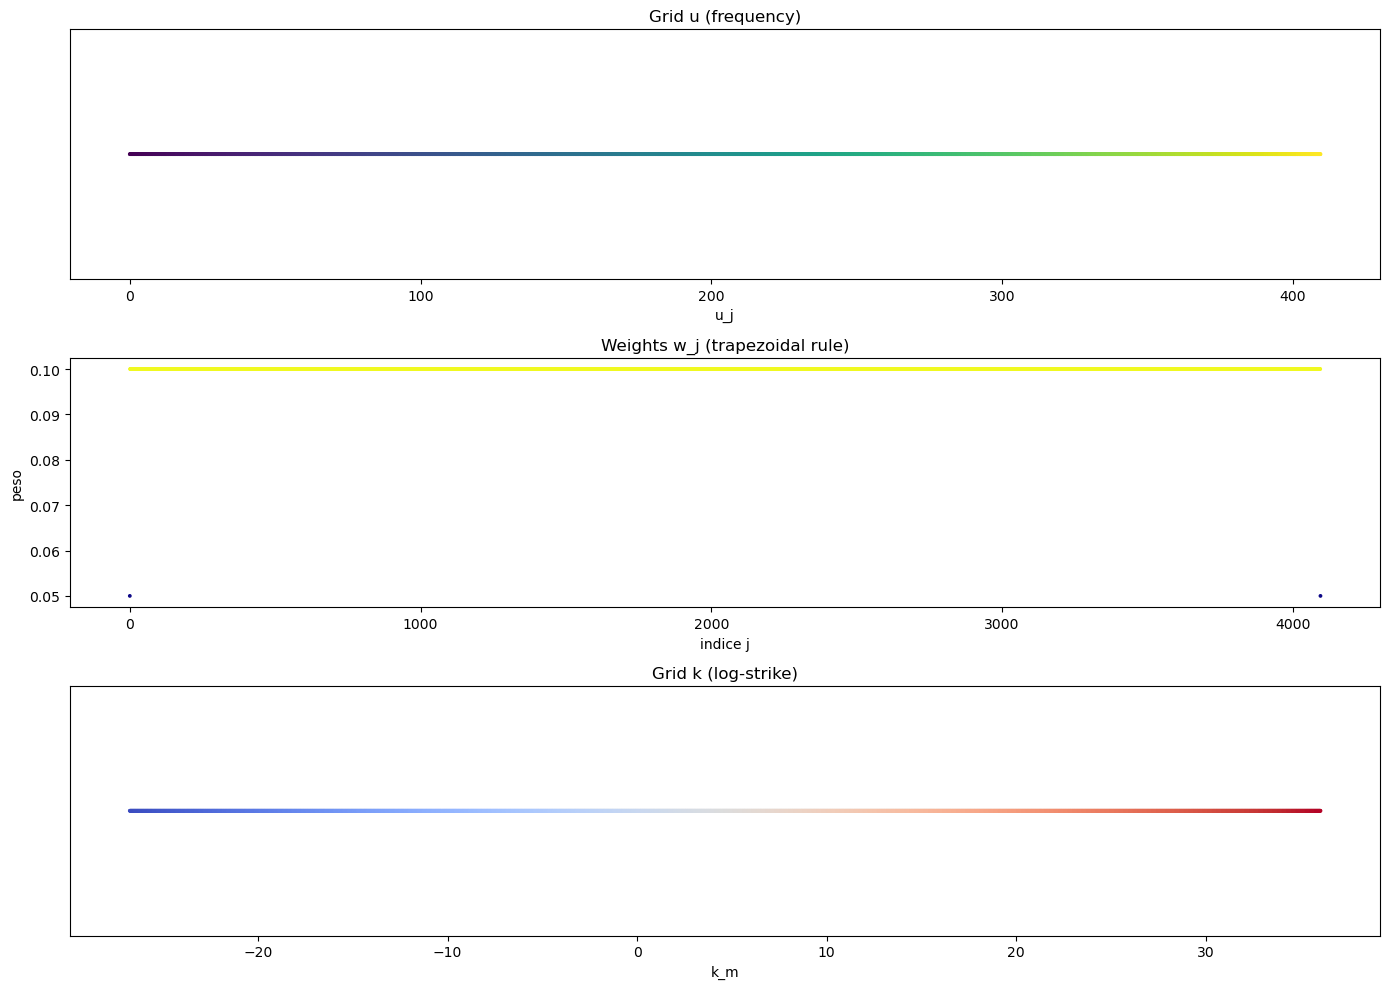

In [44]:
plt.figure(figsize=(14, 10))

# ---- u-grid ----
plt.subplot(3, 1, 1)
plt.scatter(u, np.zeros_like(u), c=u, cmap='viridis', s=3)
plt.title("Grid u (frequency)")
plt.xlabel("u_j")
plt.yticks([])

# ---- weights ----
plt.subplot(3, 1, 2)
plt.scatter(np.arange(N), w, c=w, cmap='plasma', s=3)
plt.title("Weights w_j (trapezoidal rule)")
plt.xlabel("indice j")
plt.ylabel("peso")

# ---- k-grid ----
plt.subplot(3, 1, 3)
plt.scatter(k_grid, np.zeros_like(k_grid), c=k_grid, cmap='coolwarm', s=3)
plt.title("Grid k (log-strike)")
plt.xlabel("k_m")
plt.yticks([])

plt.tight_layout()
plt.show()

We are interested in $ C(\ln K)$:

In [45]:
# Interpolation
k_target = np.log(K)
# se il punto è fuori dalla griglia, prendi il primo valore o l'ultimo (i più vicini)
if k_target <= k_grid[0]: 
    price_call = C_k[0]
elif k_target >= k_grid[-1]:
    price_call = C_k[-1]
else: # se troviamo due nodi tra cui interpolare
    idx = np.searchsorted(k_grid, k_target) - 1
    t = (k_target - k_grid[idx]) / (k_grid[idx+1] - k_grid[idx])
    price_call = C_k[idx] * (1 - t) + C_k[idx+1] * t

print('call price: ', price_call)

call price:  4.569227828524559
